In [1]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize

### Read in datasets

In [2]:
collections = pd.read_csv('collections.csv').drop(columns = ['Unnamed: 0'])
collections = collections.sort_values('designer').sort_values('seasonyear')
collections['id'] = collections.index
collections.head()

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...,2,work pinstrip power materi season time spot re...,0.235294,0.172794,2
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h...",3,hadid remind follow timeless appeal april appe...,0.235294,0.172794,2
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog...",4,told gift oneself appeal attract opposit sex s...,0.984848,0.969464,5


In [3]:
collections.shape

(14261, 10)

In [4]:
designers = pd.read_csv('designers.csv').drop(columns = ['Unnamed: 0'])
designers.head()

,designer,collections,first_season,consistency,prevalence,class
0,comme-des-garcons,65,1991.0,0.984848,0.969464,5
1,versace,61,1991.0,0.924242,0.907849,4
2,alexander-mcqueen,57,1995.0,0.982759,0.965215,5
3,prada,57,1992.0,0.890625,0.873081,4
4,miu-miu,55,1995.1,0.964912,0.946730,5


In [5]:
designers.shape

(1285, 6)

In [6]:
collections['tokens'] = [word_tokenize(sentence) for sentence in collections['preprocessed_sentences']]
sample_tokens = (collections[['id','tokens']].explode('tokens'))
sample_tokens.head()

,id,tokens
0,0,enfilad
0,0,stretchi
0,0,knit
0,0,jewel
0,0,tone


### Exploratory data analysis & visualizations

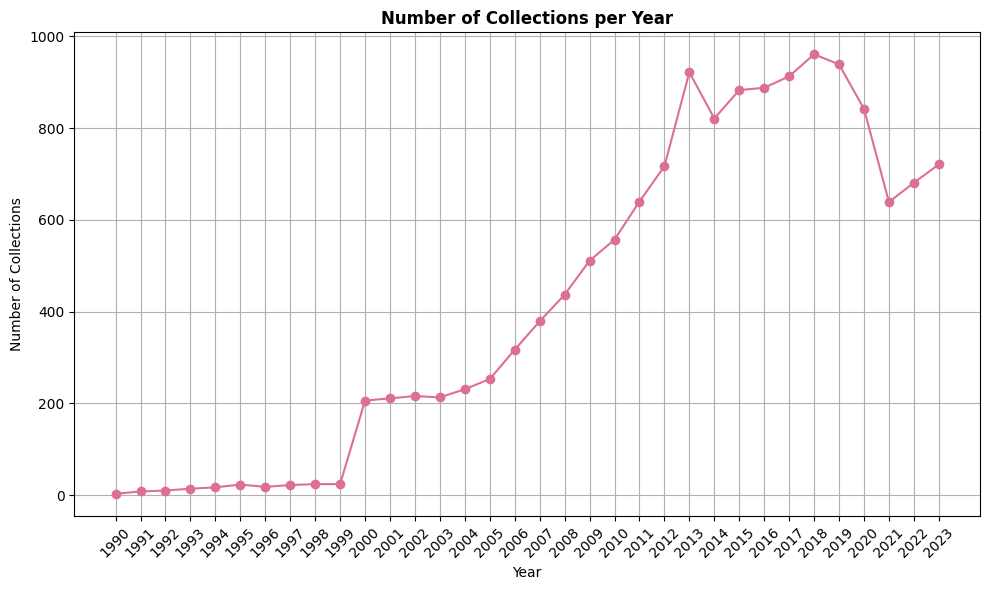

In [7]:
collections_per_year = collections.groupby(collections['year']).size()

# Plotting
plt.figure(figsize=(10, 6))
collections_per_year.plot(kind='line', marker='o', color='palevioletred')
plt.title('Number of Collections per Year', fontdict = {'fontweight':'bold'})
plt.xlabel('Year')
plt.ylabel('Number of Collections')
plt.grid(True)
plt.xticks(collections_per_year.index, rotation=45)
plt.tight_layout()
plt.show()


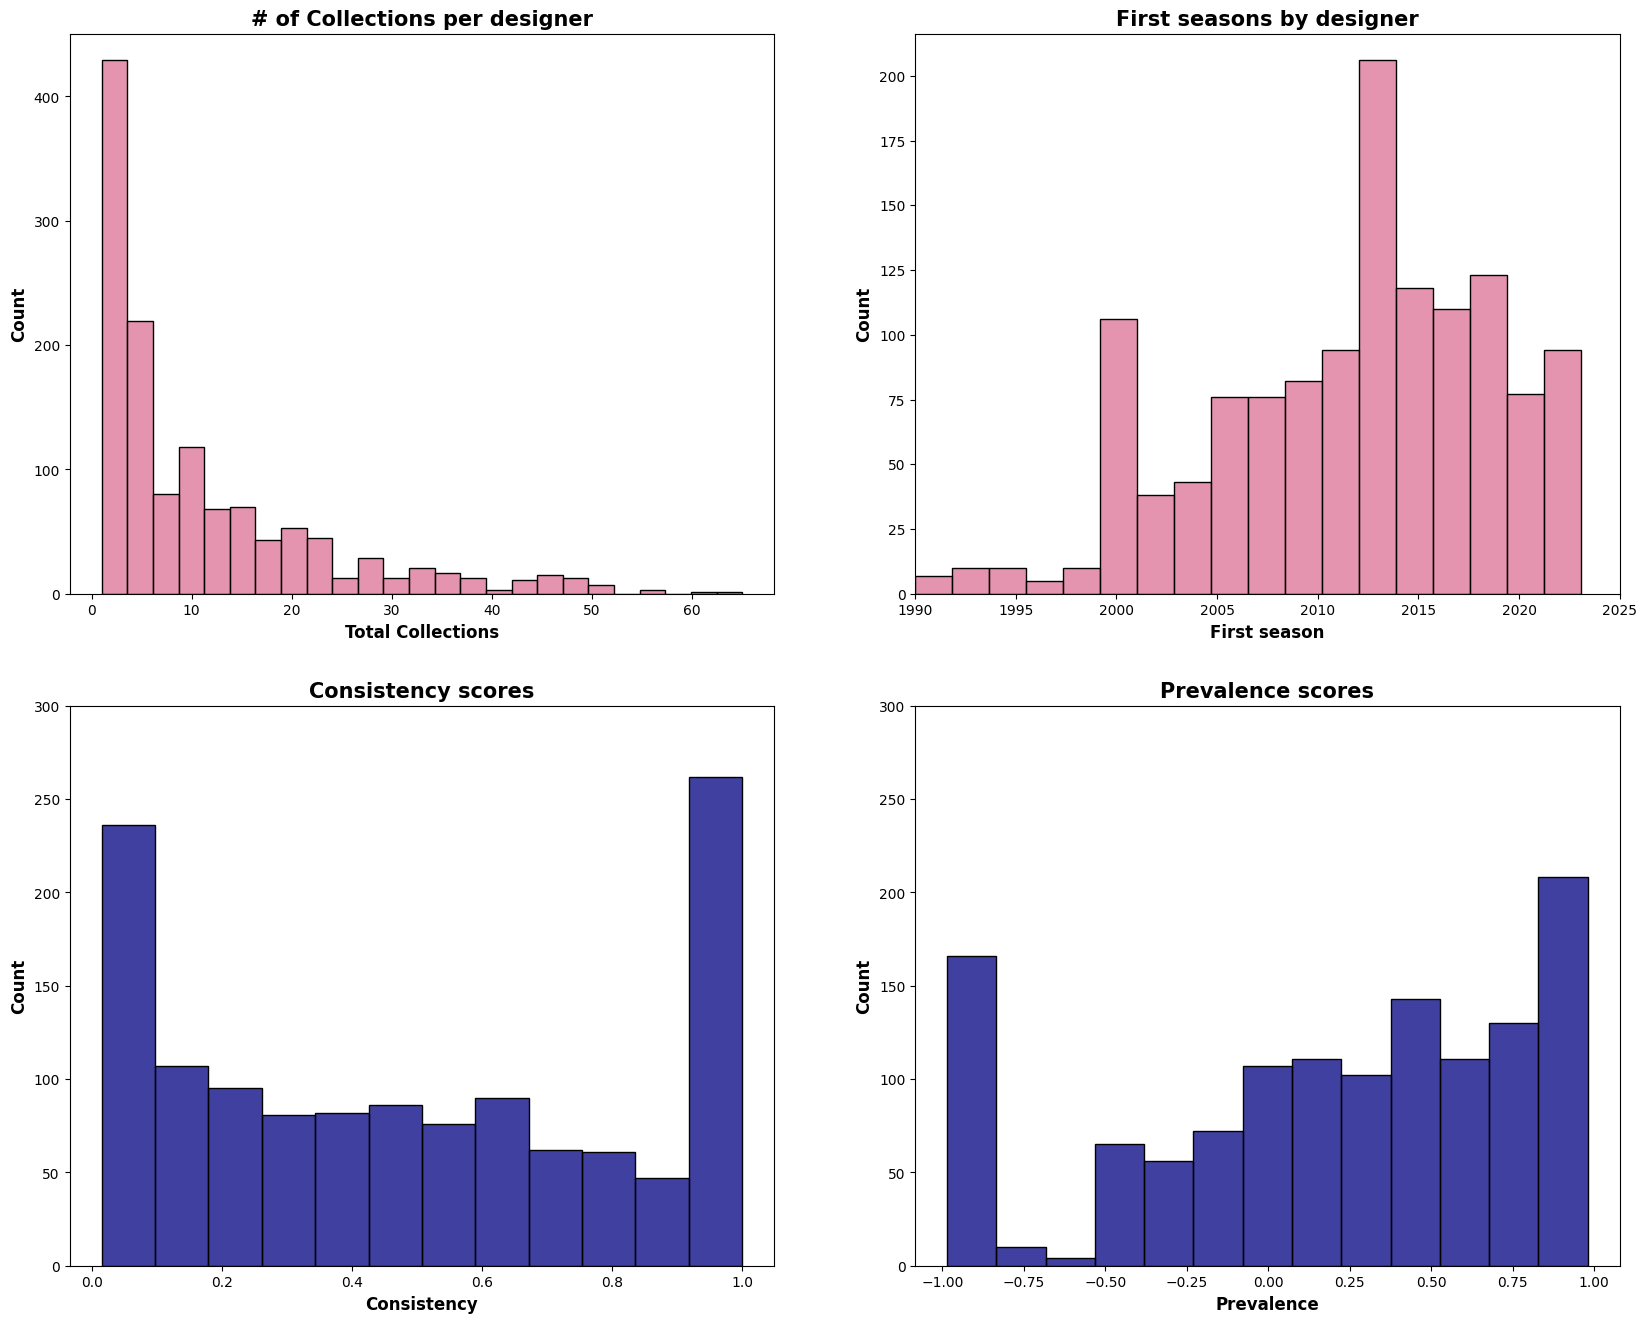

In [8]:
# plot the distributions of classes, collections, and first seasons
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# distribution of total collections
sns.histplot(data=designers,color = 'palevioletred', x = 'collections', bins="auto", ax = ax[0,0])
ax[0,0].set_title('# of Collections per designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,0].set_xlabel('Total Collections', fontsize = 12, fontweight='bold') 
ax[0,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of initial seasons 
sns.histplot(data=designers, color = 'palevioletred',x = 'first_season', ax = ax[0,1])
ax[0,1].set_xlim(1990,2025)
ax[0,1].set_title('First seasons by designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,1].set_xlabel('First season', fontsize = 12, fontweight='bold') 
ax[0,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of prevalance scores 
sns.histplot(data=designers, color = 'navy', x = 'prevalence', bins="auto", ax = ax[1,1])
ax[1,1].set_title('Prevalence scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,1].set_xlabel('Prevalence', fontsize = 12, fontweight='bold') 
ax[1,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of consistency scores 
sns.histplot(data=designers,color ='navy', x = 'consistency', bins="auto", ax = ax[1,0])
ax[1,0].set_title('Consistency scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,0].set_xlabel('Consistency', fontsize = 12, fontweight='bold') 
ax[1,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# Set the same y-axis limits for bottom two plots
ax[1,0].set_ylim(0, 300)
ax[1,1].set_ylim(0, 300)

plt.show()

In [9]:
from nltk.tokenize import word_tokenize
preprocessed = [sentence for sentence in collections['preprocessed_sentences']]
collections['tokens'] = [word_tokenize(sentence) for sentence in preprocessed]

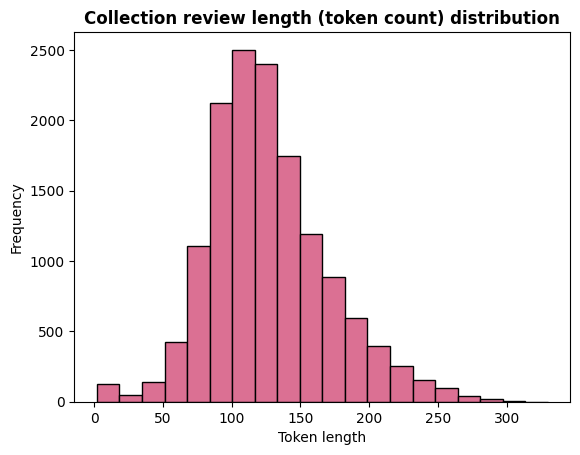

In [10]:
# plot the token length distribution using pandas
collections['length'] = collections['tokens'].apply(len)
collections['tokens'].apply(len).hist(bins=20, edgecolor = 'black', color='palevioletred')
plt.title('Collection review length (token count) distribution',fontdict = {'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Token length')
plt.grid(False)
plt.ylabel('Frequency')
plt.show()

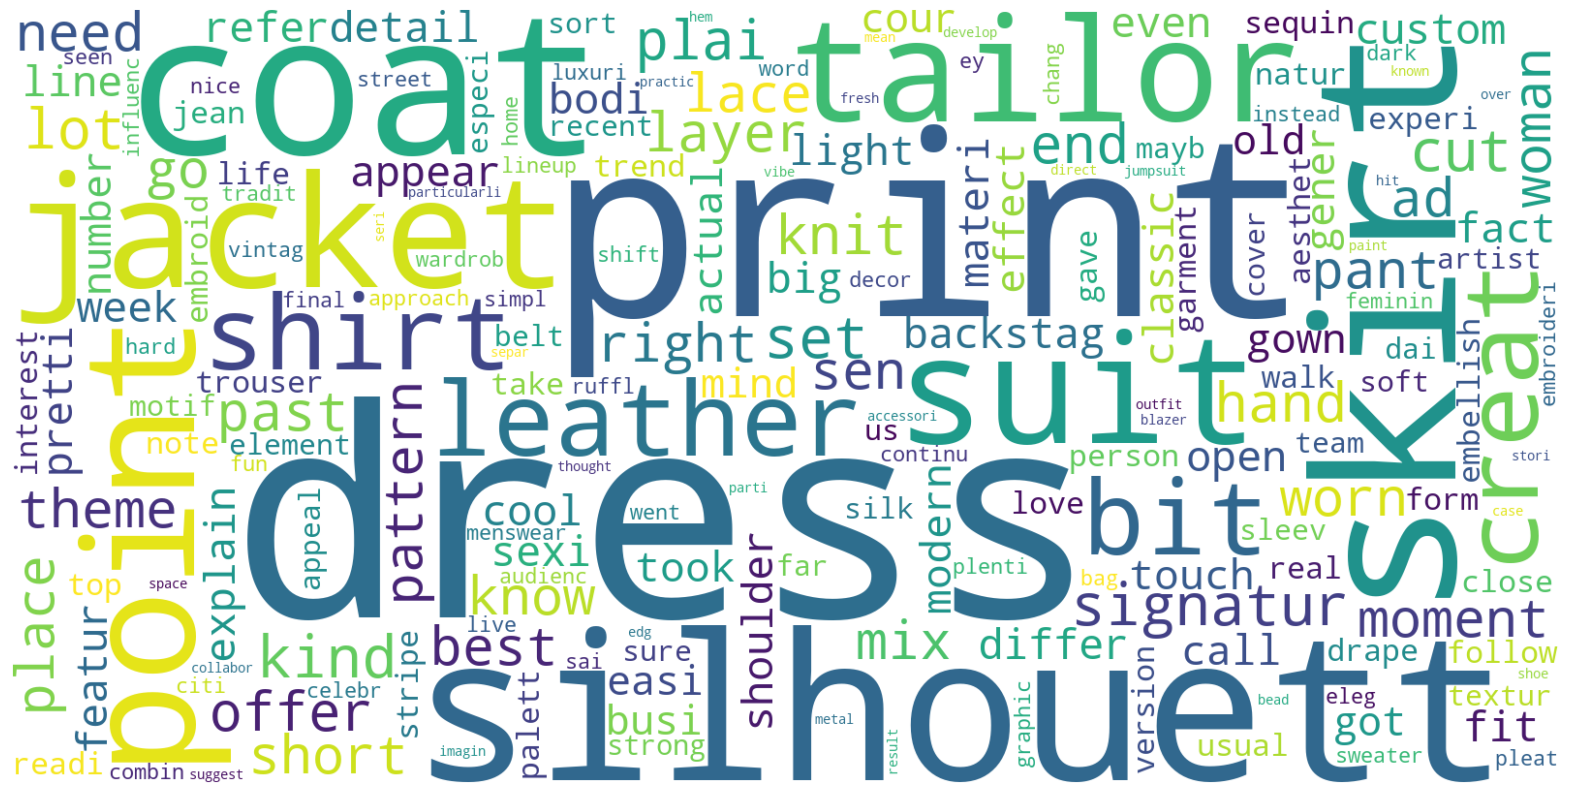

In [11]:
from wordcloud import WordCloud
stopwords = ['season','wai','good','pair','year','felt','focu','start','make', 'look','men','littl','present','fabric','girl','shape','includ', 'collect', 'show','wear','women','runwai','model', 'think','color','want','feel', 'inspir','come', 'fall','spring', 'work', 'show','like', 'todai','came','thing', 'look','design','cloth','piec','time','work','said','style','idea','turn']
wc = WordCloud(stopwords = stopwords, background_color="white", max_font_size= 300,  width=1600, height=800).generate(' '.join(sample_tokens['tokens']))

plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

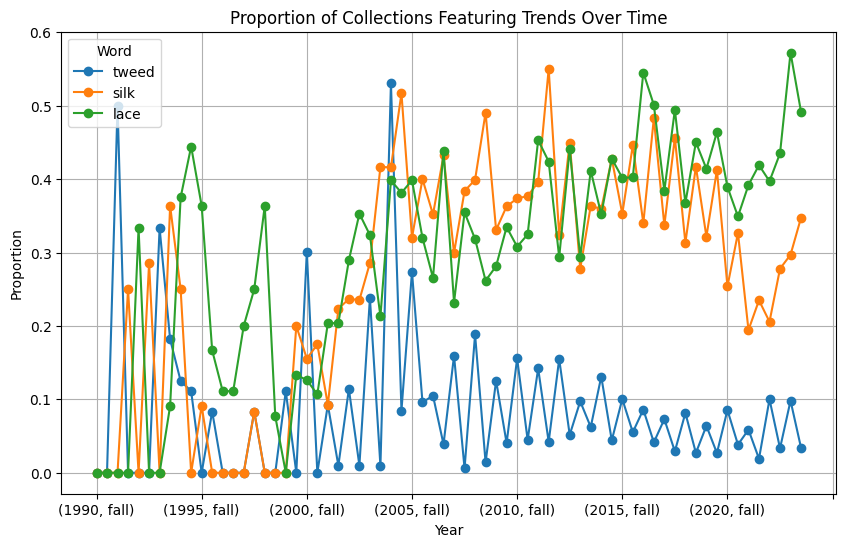

In [12]:
# analyze popularity of certain words over time

words_to_track = ['tweed', 'silk', 'lace'] 

# calculate the frequency of each word in each season or year
word_freq_over_time = collections.groupby(['year', 'season'])['preprocessed_sentences'].apply(
    lambda x: pd.Series([x.str.count(word).sum() for word in words_to_track], index=words_to_track)).unstack()

total_collections_per_season = collections.groupby(['year', 'season'])['id'].count()

# Calculate the proportion of collections containing each word for each season or year
word_prop_over_time = word_freq_over_time.div(total_collections_per_season, axis=0)

word_prop_over_time.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Proportion of Collections Featuring Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(title='Word')
plt.grid(True)
plt.show()

In [13]:
subset = collections[collections['year']>=1990].copy()
subset = subset[subset['year']<=1995]
subset_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens['tokens'].value_counts()[70:100]

tokens
plai        2645
lot         2612
make        2600
bit         2589
creat       2575
kind        2542
line        2526
top         2507
stripe      2494
signatur    2462
floral      2459
sweater     2444
right       2415
sens        2389
pattern     2379
pleat       2377
even        2360
best        2347
end         2344
woman       2342
pink        2326
past        2319
week        2294
offer       2293
fit         2250
big         2224
theme       2200
open        2171
differ      2165
mix         2164
Name: count, dtype: int64

### TF-IDF Analysis

In [16]:
from sklearn import preprocessing
def tfidf(tokens):
    # create a word frequency dataframe
    term_frequency = (tokens
                      .groupby(by=['id', 'tokens'])
                      .agg({'tokens': 'count'})
                      .rename(columns={'tokens': 'term_frequency'})
                      .reset_index()
                      .rename(columns={'tokens': 'term'}))
    
    document_frequency = (term_frequency
                      .groupby(['id', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'}))

    # merge dataframes
    term_frequency = term_frequency.merge(document_frequency)

    documents_in_corpus = term_frequency['id'].nunique()

    term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
    term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
    
    term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')

    return term_frequency.sort_values(by=['tfidf_norm'], ascending=False).groupby(['term']).head()

In [17]:
tfidf(sample_tokens)

,id,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
1613977,14031,abijako,14,1.0,9.872207,138.210895,0.020064
639426,7076,review,19,179.0,5.372397,102.075545,0.014818
1611773,13296,linnetz,11,5.0,8.773594,96.509539,0.014010
1606861,10619,dough,10,2.0,9.466742,94.667416,0.013743
1612745,13283,yadda,9,1.0,9.872207,88.849861,0.012898
...,...,...,...,...,...,...,...
1424557,718,conjur,1,347.0,4.713151,4.713151,0.000684
461713,242,accessor,1,357.0,4.684821,4.684821,0.000680
461715,334,accessor,1,357.0,4.684821,4.684821,0.000680
956397,6406,strongest,1,363.0,4.668200,4.668200,0.000678


### Use NER training dataset to see which fashion terms have the highest influence in different time periods (according to normalized tfidf)

In [26]:
word_labels = pd.read_csv('word_labels_updated.csv').drop(columns = 'Unnamed: 0')
word_labels.head()

,word,label
0,alizarin,COLOR
1,amaranth,COLOR
2,amber,COLOR
3,amethyst,COLOR
4,apricot,COLOR


In [27]:
word_labels.shape

(805, 2)

In [28]:
word_labels = word_labels[word_labels['label']!='GARMENT_TYPE']
word_labels

In [114]:
terms = pd.DataFrame()

In [115]:
# 1990-1994
subset = collections[collections['year']>=1990].copy()
subset = collections[collections['year']<=1994].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['1990-1994'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
48,fring,2.000000,1.0,4.198673,8.397346,0.108856
47,forest,2.000000,1.0,4.198673,8.397346,0.108856
94,quilt,2.000000,1.0,4.198673,8.397346,0.108856
54,harlequin,2.000000,1.0,4.198673,8.397346,0.108856
6,baroqu,2.000000,1.0,4.198673,8.397346,0.108856
45,flare,2.000000,1.0,4.198673,8.397346,0.108856
142,wool,2.000000,1.0,4.198673,8.397346,0.108856
134,ultrasued,2.000000,1.0,4.198673,8.397346,0.108856
132,tull,2.000000,1.0,4.198673,8.397346,0.108856
135,velvet,1.666667,3.0,3.505526,5.842543,0.075737


In [116]:
# 1995-1999
subset = collections[collections['year']>=1995].copy()
subset = collections[collections['year']<=1999].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['1995-1999'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
26,casual,4.0,1.0,5.356709,21.426835,0.142975
103,lilac,2.0,1.0,5.356709,10.713418,0.071488
83,harlequin,2.0,1.0,5.356709,10.713418,0.071488
204,ultrasued,2.0,1.0,5.356709,10.713418,0.071488
65,flare,2.0,1.0,5.356709,10.713418,0.071488
8,baroqu,2.0,1.0,5.356709,10.713418,0.071488
29,chenil,2.0,1.0,5.356709,10.713418,0.071488
108,loos,2.0,1.0,5.356709,10.713418,0.071488
139,pleat,2.2,5.0,4.258097,9.367812,0.062509
144,print,3.4,37.0,2.412270,8.201717,0.054728


In [117]:
# 2000-2004
subset = collections[collections['year']>=2000].copy()
subset = collections[collections['year']<=2004].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['2000-2004'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
47,chantilli,1.666667,3.0,6.726848,11.211413,0.021846
162,lame,2.400000,36.0,4.502224,10.805338,0.021055
137,grung,2.000000,16.0,5.279929,10.559858,0.020576
15,baroqu,1.500000,2.0,7.014530,10.521795,0.020502
151,ivori,2.600000,59.0,4.018798,10.448874,0.020360
159,knit,3.800000,218.0,2.724070,10.351467,0.020170
87,dot,2.400000,46.0,4.262995,10.231187,0.019936
23,blue,3.400000,178.0,2.925756,9.947571,0.019383
63,collar,2.800000,96.0,3.538431,9.907607,0.019305
160,lace,3.400000,183.0,2.898206,9.853902,0.019201


In [118]:
# 2005-2009
subset = collections[collections['year']>=2005].copy()
subset = collections[collections['year']<=2009].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['2005-2009'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
355,tartan,2.6,38.0,5.383628,13.997433,0.016841
176,lace,4.6,496.0,2.838600,13.057558,0.015711
381,velvet,3.8,295.0,3.356830,12.755954,0.015348
344,stripe,3.8,381.0,3.101769,11.786722,0.014181
258,pleat,4.0,462.0,2.909463,11.637850,0.014002
1,african,2.2,46.0,5.197042,11.433492,0.013757
169,japanes,2.6,105.0,4.383750,11.397751,0.013713
15,baroqu,1.8,16.0,6.213976,11.185157,0.013458
47,cashmer,3.2,261.0,3.478845,11.132304,0.013394
265,print,5.4,1092.0,2.050508,11.072744,0.013322


In [119]:
# 2010-2014
subset = collections[collections['year']>=2010].copy()
subset = collections[collections['year']<=2014].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['2010-2014'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
363,tan,4.0,20.0,6.776325,27.105298,0.021409
71,classic,5.8,749.0,3.200774,18.564488,0.014663
158,grung,3.4,81.0,5.414128,18.408034,0.014540
323,sequin,5.4,686.0,3.288513,17.757969,0.014026
51,cashmer,4.4,457.0,3.693978,16.253503,0.012838
265,pleat,5.6,1013.0,2.899189,16.235458,0.012824
263,plaid,4.0,330.0,4.018729,16.074915,0.012697
88,crochet,3.4,166.0,4.702853,15.989701,0.012629
366,tartan,2.8,89.0,5.321037,14.898905,0.011768
175,japanes,3.4,230.0,4.378429,14.886660,0.011758


In [120]:
# 2015-2019
subset = collections[collections['year']>=2015].copy()
subset = collections[collections['year']<=2019].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['2015-2019'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf_norm', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
369,tan,6.8,43.0,6.553224,44.561922,0.026206
366,sustain,4.8,196.0,5.054210,24.260207,0.014267
163,grung,4.4,163.0,5.237547,23.045207,0.013553
400,velour,3.4,47.0,6.466212,21.985122,0.012929
329,sequin,6.8,1220.0,3.229988,21.963918,0.012917
256,paislei,4.2,193.0,5.069555,21.292132,0.012522
401,velvet,6.0,1156.0,3.283828,19.702966,0.011587
54,cashmer,5.2,757.0,3.706730,19.274996,0.011335
75,classic,6.0,1256.0,3.200930,19.205581,0.011295
92,crochet,4.2,329.0,4.538321,19.060947,0.011210


In [121]:
# 2020s
subset = collections[collections['year']>=2020].copy()
subset = collections[collections['year']<=2024].copy()

subset['tokens'] = [word_tokenize(sentence) for sentence in subset['preprocessed_sentences']]
sample_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens = sample_tokens[sample_tokens['tokens'].isin(word_labels['word'])]

output = tfidf(sample_tokens).groupby('term').agg({
    'term_frequency': 'mean',  
    'document_frequency': 'mean',  
    'idf': 'max',  
    'tfidf': 'mean', 
    'tfidf_norm': 'mean'  
}).reset_index()
output.columns = ['term', 'avg_term_frequency', 'document_frequency', 'idf', 'tfidf',
       'tfidf_norm']
terms['2020-2023'] = list(output.sort_values('tfidf_norm', ascending = False).head(10)['term'])
output.sort_values('tfidf_norm', ascending = False).head(10)

,term,avg_term_frequency,document_frequency,idf,tfidf,tfidf_norm
372,tan,6.8,58.0,6.485922,44.104267,0.022860
416,white,6.6,963.0,3.692368,24.369627,0.012631
215,mermaid,4.0,92.0,6.030860,24.123438,0.012504
369,sustain,5.4,482.0,4.383442,23.670589,0.012269
164,grung,4.4,210.0,5.211601,22.931044,0.011886
331,sequin,7.0,1588.0,3.192599,22.348192,0.011583
414,wheat,3.0,22.0,7.427965,22.283894,0.011550
403,velour,3.4,70.0,6.300779,21.422649,0.011104
257,paislei,4.2,237.0,5.091188,21.382991,0.011083
172,hollywood,4.4,373.0,4.639203,20.412494,0.010580


In [122]:
terms

,1990-1994,1995-1999,2000-2004,2005-2009,2010-2014,2015-2019,2020-2023
0,fring,casual,chantilli,tartan,tan,tan,tan
1,forest,lilac,lame,lace,classic,sustain,white
2,quilt,harlequin,grung,velvet,grung,grung,mermaid
3,harlequin,ultrasued,baroqu,stripe,sequin,velour,sustain
4,baroqu,flare,ivori,pleat,cashmer,sequin,grung
5,flare,baroqu,knit,african,pleat,paislei,sequin
6,wool,chenil,dot,japanes,plaid,velvet,wheat
7,ultrasued,loos,blue,baroqu,crochet,cashmer,velour
8,tull,pleat,collar,cashmer,tartan,classic,paislei
9,velvet,print,lace,print,japanes,crochet,hollywood


### Fitting a Naive Bayes classifier to evaluate word significance and predict class of designer based on collection description
Using the collections dataframe, we use a supervised learning algorithm to classify the designer collections.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

subset = collections[collections['seasonyear']>1990.1]

X = subset['preprocessed_sentences']
y = subset['season']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [75]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_test_le = label_encoder.transform(y_test)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_test_le.shape}')

Label encoded training labels shape: (10693,)
Label encoded validation labels shape: (3565,)


In [76]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_train = cv.fit_transform(X_train.values)
X_test = cv.transform(X_test.values)

nb_model =  MultinomialNB()
nb_model.fit(X_train, y_train_le)

# Predict the authors of validation dataset
nb_predictions = nb_model.predict(X_test)

print(nb_model.score(X_test, y_test_le))

0.8311360448807854


### SVC
Predicting the season of a designer based on their collection description.

In [22]:
# Separate features and target
X = collections['preprocessed_sentences']
y = collections['season']

In [23]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify = y)

X_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify = y_test, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

Training samples: 9982
Validation samples: 2852


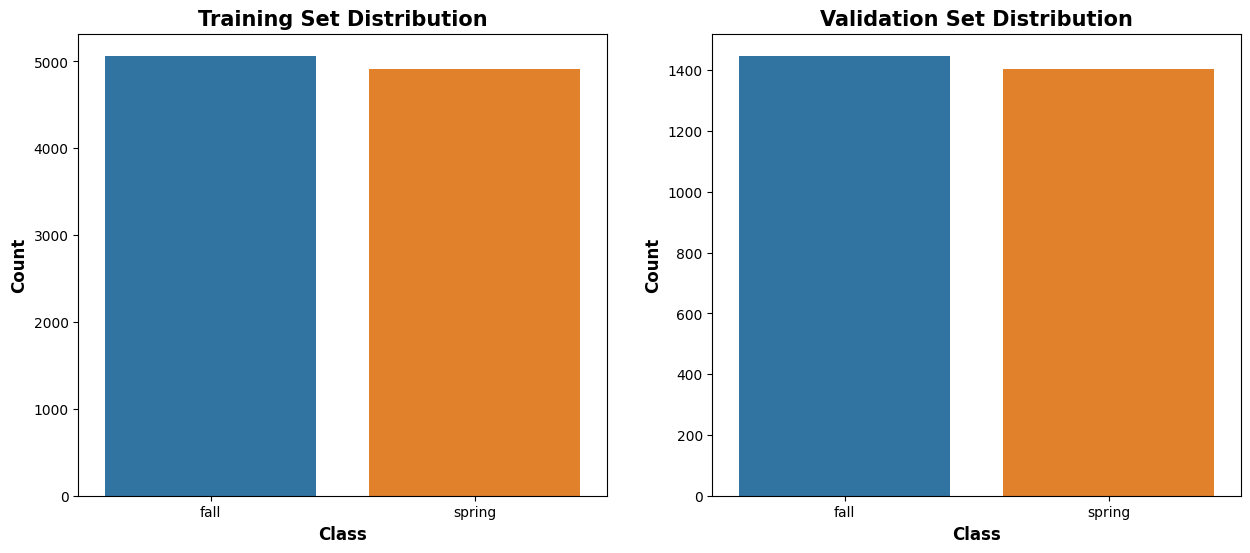

In [24]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# first plot is the training set
sns.countplot(data = y_train.to_frame(name = 'Class').sort_values('Class'), x = 'Class',ax=ax[0])
ax[0].set_title('Training Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0].set_xlabel('Class', fontsize = 12, fontweight='bold') 
ax[0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# second plot is the validation set

sns.countplot(data = y_val.to_frame(name = 'Class').sort_values('Class'), x = 'Class', ax=ax[1])
ax[1].set_title('Validation Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1].set_xlabel('Class', fontsize = 12, fontweight='bold') 
ax[1].set_ylabel('Count', fontsize = 12, fontweight='bold') 
plt.show()

In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe = ohe.fit_transform(np.array(y_val).reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (9982, 2)
One hot encoded validation labels shape: (2852, 2)


In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.fit_transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (9982,)
Label encoded validation labels shape: (2852,)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import time

In [28]:
start_time = time.time()
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', SVC(kernel='rbf', C = 1.51, random_state=42))
])
# fit the model
text_clf.fit(X_train, y_train_le)
end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time:", execution_time, "seconds")

Execution time: 581.1311118602753 seconds


In [29]:
text_clf.score(X_val, y_val_le)

0.8727208976157083

In [30]:
y_pred = text_clf.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val_le, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1448
           1       0.88      0.86      0.87      1404

    accuracy                           0.87      2852
   macro avg       0.87      0.87      0.87      2852
weighted avg       0.87      0.87      0.87      2852

